In [145]:
import os
import time
import datetime
import json
import gc
from numba import jit

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

from itertools import product

import altair as alt
from altair.vega import v5
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v5.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

@jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc


def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
    return 'auc', fast_auc(y_true, y_pred), True


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true-y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
    

def train_model_regression(X, X_test, y, params, folds=None, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    X_test = X_test[columns]
    splits = folds.split(X) if splits is None else splits
    n_splits = folds.n_splits if splits is None else n_folds
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error},
                    'group_mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'scoring_function': group_mean_log_mae},
                    'mse': {'lgb_metric_name': 'mse',
                        'catboost_metric_name': 'MSE',
                        'sklearn_scoring_function': metrics.mean_squared_error}
                    }

    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(splits):
        if verbose:
            print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_estimators, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        if eval_metric != 'group_mae':
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
        else:
            scores.append(metrics_dict[eval_metric]['scoring_function'](y_valid, y_pred_valid, X_valid['type']))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict
    


def train_model_classification(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None, plot_feature_importance=False, model=None,
                               verbose=10000, early_stopping_rounds=200, n_estimators=50000, splits=None, n_folds=3, averaging='usual', n_jobs=-1):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else n_folds
    X_test = X_test.values
    
    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                        'catboost_metric_name': 'AUC',
                        'sklearn_scoring_function': metrics.roc_auc_score},
                    }
    
    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))
        
    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        prediction = np.zeros((len(X_test), 1))

    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X,y)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs = n_jobs)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict_proba(X_test)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=Logloss)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        if averaging == 'usual':
            
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            
            prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':
                                  
            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
                                  
            prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)        
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
        
    return result_dict

# setting up altair
workaround = prepare_altair()
HTML("".join((
    "<script>",
    workaround,
    "</script>",
)))

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [146]:
train_identity= pd.read_csv('C:/NEW/fintech/新训练数据集/训练数据集/训练数据集_tag.csv',
                                     na_values=['\\N',' ','~','nan'])
train_trade = pd.read_csv('C:/NEW/fintech/新训练数据集/训练数据集/训练数据集_trd.csv')
train_behavior = pd.read_csv('C:/NEW/fintech/新训练数据集/训练数据集/训练数据集_beh.csv',header=0,usecols=[0,1,2,3],names=['id','flag','page_no','page_tm'])
test_identity= pd.read_csv('C:/NEW/fintech/评分数据集b/b/评分数据集_tag_b.csv',
                                     na_values=['\\N',' ','~','nan'])
test_trade = pd.read_csv('C:/NEW/fintech/评分数据集b/b/评分数据集_trd_b.csv')
test_behavior = pd.read_csv('C:/NEW/fintech/评分数据集b/b/评分数据集_beh_b.csv',header=0,usecols=[0,1,2],names=['id','page_no','page_tm'])

In [147]:
train_trd_cny = train_trade.groupby(['id'])['cny_trx_amt'].agg(['sum','mean','std','min','max'])
train_trd_cny.columns = ['trd_amt_amt','trd_amt_avg','trd_amt_std', 'trd_amt_min','trd_amt_max']
train_trd_cny.reset_index()

Dat_Flg1_Cd_column_names = train_trade['Dat_Flg1_Cd'].unique()
Dat_Flg1_Cd_columns = pd.DataFrame(columns = Dat_Flg1_Cd_column_names)
for v in Dat_Flg1_Cd_column_names:
    Dat_Flg1_Cd_columns[v]=train_trade[train_trade['Dat_Flg1_Cd']==v].groupby('id')['id'].count()

Dat_Flg1_Cd_columns = Dat_Flg1_Cd_columns.reset_index()
Dat_Flg1_Cd_columns.columns = ['id','expense_cnt', 'income_cnt']

Dat_Flg1_Cd_amt = pd.DataFrame(columns = Dat_Flg1_Cd_column_names)
for v in Dat_Flg1_Cd_column_names:
    Dat_Flg1_Cd_amt[v]=train_trade[train_trade['Dat_Flg1_Cd']==v].groupby('id')['cny_trx_amt'].sum()

Dat_Flg1_Cd_amt = Dat_Flg1_Cd_amt.reset_index()
Dat_Flg1_Cd_amt.columns = ['id','expense_amt', 'income_amt']

Dat_Flg1_Cd_avg = pd.DataFrame(columns = Dat_Flg1_Cd_column_names)
for v in Dat_Flg1_Cd_column_names:
    Dat_Flg1_Cd_avg[v]=train_trade[train_trade['Dat_Flg1_Cd']==v].groupby('id')['cny_trx_amt'].mean()

Dat_Flg1_Cd_avg = Dat_Flg1_Cd_avg.reset_index()
Dat_Flg1_Cd_avg.columns = ['id','expense_avg', 'income_avg']

Dat_Flg3_Cd_column_names = train_trade['Dat_Flg3_Cd'].unique()
Dat_Flg3_Cd_columns = pd.DataFrame(columns = Dat_Flg3_Cd_column_names)
for v in Dat_Flg3_Cd_column_names:
    Dat_Flg3_Cd_columns[v]=train_trade[train_trade['Dat_Flg3_Cd']==v].groupby('id')['cny_trx_amt'].sum()

Dat_Flg3_Cd_columns = Dat_Flg3_Cd_columns.reset_index()
Dat_Flg3_Cd_columns.columns = ['id','methodB_amt', 'methodA_amt','methodC_amt']
Dat_Flg3_Cd_column_names = train_trade['Dat_Flg3_Cd'].unique()
Dat_Flg3_Cd_avg = pd.DataFrame(columns = Dat_Flg3_Cd_column_names)
for v in Dat_Flg3_Cd_column_names:
    Dat_Flg3_Cd_avg[v]=train_trade[train_trade['Dat_Flg3_Cd']==v].groupby('id')['cny_trx_amt'].mean()

Dat_Flg3_Cd_avg = Dat_Flg3_Cd_avg.reset_index()
Dat_Flg3_Cd_avg.columns = ['id','methodB_avg', 'methodA_avg','methodC_avg']

Dat_Flg3_Cd_column_names = train_trade['Dat_Flg3_Cd'].unique()
Dat_Flg3_Cd_std = pd.DataFrame(columns = Dat_Flg3_Cd_column_names)
for v in Dat_Flg3_Cd_column_names:
    Dat_Flg3_Cd_std[v]=train_trade[train_trade['Dat_Flg3_Cd']==v].groupby('id')['cny_trx_amt'].std()

Dat_Flg3_Cd_std = Dat_Flg3_Cd_std.reset_index()
Dat_Flg3_Cd_std.columns = ['id','methodB_std', 'methodA_std','methodC_std']

train_page_cnt = train_behavior.groupby('id')['page_no'].count()
train_page_cnt = train_page_cnt.reset_index()
train_page_cnt.columns = ['id','total_page_cnt']

page_no_column_names = train_behavior['page_no'].unique()
page_no_columns = pd.DataFrame(columns = page_no_column_names)
for v in page_no_column_names:
    page_no_columns[v]=train_behavior[train_behavior['page_no']==v].groupby('id')['id'].count()

page_no_columns = page_no_columns.reset_index()

train_trade['trx_tm'] = pd.to_datetime(train_trade['trx_tm'])
train_trade['day_of_week'] = train_trade['trx_tm'].dt.day_name()

train_weekday_names = train_trade['day_of_week'].unique()
train_weekday = pd.DataFrame(columns = train_weekday_names)
for v in train_weekday_names:
    train_weekday[v]=train_trade[train_trade['day_of_week']==v].groupby(['id','day_of_week'])['cny_trx_amt'].sum()

train_weekday = train_weekday.reset_index()
train_weekday=train_weekday.drop('day_of_week',axis=1)

train_behavior['date'] = pd.to_datetime(
    train_behavior['page_tm']).dt.floor('D')

train_dailycount=train_behavior.groupby(['id','date'])['page_no'].count()
train_dailycount=train_dailycount.reset_index()
train_dailycountmax=train_dailycount.groupby('id')['page_no'].max()
train_dailycountmax=train_dailycountmax.reset_index()

train_merge1 = train_identity.merge(train_trd_cny,on='id',how='left')
train_merge2 = train_merge1.merge(Dat_Flg1_Cd_columns,on='id',how='left')
train_merge3 = train_merge2.merge(Dat_Flg3_Cd_columns,on='id',how='left')
train_merge4 = train_merge3.merge(train_page_cnt,on='id',how='left')
train_merge5 = train_merge4.merge(page_no_columns,on='id',how='left')
train_merge6= train_merge5.merge(Dat_Flg3_Cd_avg,on='id',how='left')
train_merge7 = train_merge6.merge(Dat_Flg3_Cd_std,on='id',how='left')
train_merge8 = train_merge7.merge(Dat_Flg1_Cd_amt,on='id',how='left')
train_merge9 = train_merge8.merge(Dat_Flg1_Cd_avg,on='id',how='left')
train_merge10 = train_merge9.merge(train_weekday,on='id',how='left')
train_merge = train_merge10.merge(train_dailycountmax,on='id',how='left')

In [148]:
test_trd_cny = test_trade.groupby(['id'])['cny_trx_amt'].agg(['sum','mean','std','min','max'])
test_trd_cny.columns = ['trd_amt_amt','trd_amt_avg', 'trd_amt_std','trd_amt_min','trd_amt_max']
test_trd_cny = test_trd_cny.reset_index()

Dat_Flg1_Cd_column_names1 = test_trade['Dat_Flg1_Cd'].unique()
Dat_Flg1_Cd_columns1 = pd.DataFrame(columns = Dat_Flg1_Cd_column_names1)
for v in Dat_Flg1_Cd_column_names1:
    Dat_Flg1_Cd_columns1[v]=test_trade[test_trade['Dat_Flg1_Cd']==v].groupby('id')['id'].count()

Dat_Flg1_Cd_columns1 = Dat_Flg1_Cd_columns1.reset_index()
Dat_Flg1_Cd_columns1.columns = ['id','expense_cnt', 'income_cnt']

Dat_Flg1_Cd_amt1 = pd.DataFrame(columns = Dat_Flg1_Cd_column_names1)
for v in Dat_Flg1_Cd_column_names1:
    Dat_Flg1_Cd_amt1[v]=test_trade[test_trade['Dat_Flg1_Cd']==v].groupby('id')['cny_trx_amt'].sum()

Dat_Flg1_Cd_amt1 = Dat_Flg1_Cd_amt1.reset_index()
Dat_Flg1_Cd_amt1.columns = ['id','expense_amt', 'income_amt']

Dat_Flg1_Cd_avg1 = pd.DataFrame(columns = Dat_Flg1_Cd_column_names1)
for v in Dat_Flg1_Cd_column_names1:
    Dat_Flg1_Cd_avg1[v]=test_trade[test_trade['Dat_Flg1_Cd']==v].groupby('id')['cny_trx_amt'].mean()

Dat_Flg1_Cd_avg1 = Dat_Flg1_Cd_avg1.reset_index()
Dat_Flg1_Cd_avg1.columns = ['id','expense_avg', 'income_avg']

Dat_Flg3_Cd_column_names1 = test_trade['Dat_Flg3_Cd'].unique()
Dat_Flg3_Cd_columns1 = pd.DataFrame(columns = Dat_Flg3_Cd_column_names1)
for v in Dat_Flg3_Cd_column_names1:
    Dat_Flg3_Cd_columns1[v]=test_trade[test_trade['Dat_Flg3_Cd']==v].groupby('id')['cny_trx_amt'].sum()

Dat_Flg3_Cd_columns1 = Dat_Flg3_Cd_columns1.reset_index()
Dat_Flg3_Cd_columns1.columns = ['id','methodB_amt', 'methodA_amt','methodC_amt']

Dat_Flg3_Cd_column_names1 = train_trade['Dat_Flg3_Cd'].unique()
Dat_Flg3_Cd_avg1 = pd.DataFrame(columns = Dat_Flg3_Cd_column_names)
for v in Dat_Flg3_Cd_column_names1:
    Dat_Flg3_Cd_avg1[v]=test_trade[test_trade['Dat_Flg3_Cd']==v].groupby('id')['cny_trx_amt'].mean()

Dat_Flg3_Cd_avg1 = Dat_Flg3_Cd_avg1.reset_index()
Dat_Flg3_Cd_avg1.columns = ['id','methodB_avg', 'methodA_avg','methodC_avg']

Dat_Flg3_Cd_column_names1 = train_trade['Dat_Flg3_Cd'].unique()
Dat_Flg3_Cd_std1 = pd.DataFrame(columns = Dat_Flg3_Cd_column_names)
for v in Dat_Flg3_Cd_column_names1:
    Dat_Flg3_Cd_std1[v]=train_trade[train_trade['Dat_Flg3_Cd']==v].groupby('id')['cny_trx_amt'].std()

Dat_Flg3_Cd_std1 = Dat_Flg3_Cd_std1.reset_index()
Dat_Flg3_Cd_std1.columns = ['id','methodB_std', 'methodA_std','methodC_std']

test_page_cnt = test_behavior.groupby('id')['page_no'].count()
test_page_cnt = test_page_cnt.reset_index()
test_page_cnt.columns = ['id','total_page_cnt']

page_no_column_names1 = test_behavior['page_no'].unique()
page_no_columns1 = pd.DataFrame(columns = page_no_column_names1)
for v in page_no_column_names1:
    page_no_columns1[v]=test_behavior[test_behavior['page_no']==v].groupby('id')['id'].count()

page_no_columns1 = page_no_columns1.reset_index()

test_trade['trx_tm'] = pd.to_datetime(test_trade['trx_tm'])
test_trade['day_of_week'] = test_trade['trx_tm'].dt.day_name()

test_weekday_names = test_trade['day_of_week'].unique()
test_weekday = pd.DataFrame(columns = test_weekday_names)
for v in train_weekday_names:
    test_weekday[v]=test_trade[test_trade['day_of_week']==v].groupby(['id','day_of_week'])['cny_trx_amt'].sum()

test_weekday = test_weekday.reset_index()
test_weekday=test_weekday.drop('day_of_week',axis=1)

test_behavior['date'] = pd.to_datetime(
    test_behavior['page_tm']).dt.floor('D')

test_dailycount=test_behavior.groupby(['id','date'])['page_no'].count()
test_dailycount=test_dailycount.reset_index()
test_dailycountmax=test_dailycount.groupby('id')['page_no'].max()
test_dailycountmax=test_dailycountmax.reset_index()

test_merge1 = test_identity.merge(test_trd_cny,on='id',how='left')
test_merge2 = test_merge1.merge(Dat_Flg1_Cd_columns1,on='id',how='left')
test_merge3 = test_merge2.merge(Dat_Flg3_Cd_columns1,on='id',how='left')
test_merge4 = test_merge3.merge(test_page_cnt,on='id',how='left')
test_merge5 = test_merge4.merge(page_no_columns1,on='id',how='left')
test_merge6 = test_merge5.merge(Dat_Flg3_Cd_avg1,on='id',how='left')
test_merge7 = test_merge6.merge(Dat_Flg3_Cd_std1,on='id',how='left')
test_merge8 = test_merge7.merge(Dat_Flg1_Cd_amt1,on='id',how='left')
test_merge9= test_merge8.merge(Dat_Flg1_Cd_avg1,on='id',how='left')
test_merge10= test_merge9.merge(test_weekday,on='id',how='left')
test_merge= test_merge10.merge(test_dailycountmax,on='id',how='left')

In [149]:
many_null_cols = [col for col in train_merge.columns if train_merge[col].isnull().sum() / train_merge.shape[0] > 0.9]
many_null_cols_test = [col for col in test_merge.columns if test_merge[col].isnull().sum() / test_merge.shape[0] > 0.9]

In [150]:
#big_top_value_cols = [col for col in train_merge.columns if train_merge[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
#big_top_value_cols_test = [col for col in test_merge.columns if test_merge[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]

In [151]:
cols_to_drop = list(set(many_null_cols + many_null_cols_test ))

In [152]:
train = train_merge.drop(cols_to_drop, axis=1)
test = test_merge.drop(cols_to_drop, axis=1)

In [153]:
cat_cols = ['gdr_cd', 'mrg_situ_cd', 'edu_deg_cd', 'acdm_deg_cd', 'deg_cd','atdd_type']
for col in cat_cols:
    if col in train.columns:
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))   

In [154]:
X = train.drop(['id', 'flag'], axis=1)
y = train['flag']
X_test = test.drop(['id'], axis=1)
test = test[['id']]

In [155]:
def clean_inf_nan(df):
    return df.replace([np.inf, -np.inf], np.nan)   

# Cleaning infinite values to NaN
X = clean_inf_nan(X)
X_test = clean_inf_nan(X_test)

In [156]:
gc.collect()

140

In [157]:
n_folds=5
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Fold 1 started at Tue May 12 01:52:56 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.831828	training's auc: 0.831828	valid_1's auc: 0.746489	valid_1's auc: 0.746489
[1000]	training's auc: 0.862611	training's auc: 0.862611	valid_1's auc: 0.747747	valid_1's auc: 0.747747
Early stopping, best iteration is:
[957]	training's auc: 0.860555	training's auc: 0.860555	valid_1's auc: 0.747994	valid_1's auc: 0.747994
Fold 2 started at Tue May 12 01:53:21 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.832458	training's auc: 0.832458	valid_1's auc: 0.742059	valid_1's auc: 0.742059
[1000]	training's auc: 0.864744	training's auc: 0.864743	valid_1's auc: 0.742481	valid_1's auc: 0.742481
Early stopping, best iteration is:
[953]	training's auc: 0.861896	training's auc: 0.861896	valid_1's auc: 0.742697	valid_1's auc: 0.742697
Fold 3 started at Tue May 12 01:53:47 2020
Training until validation scores don't improve for 

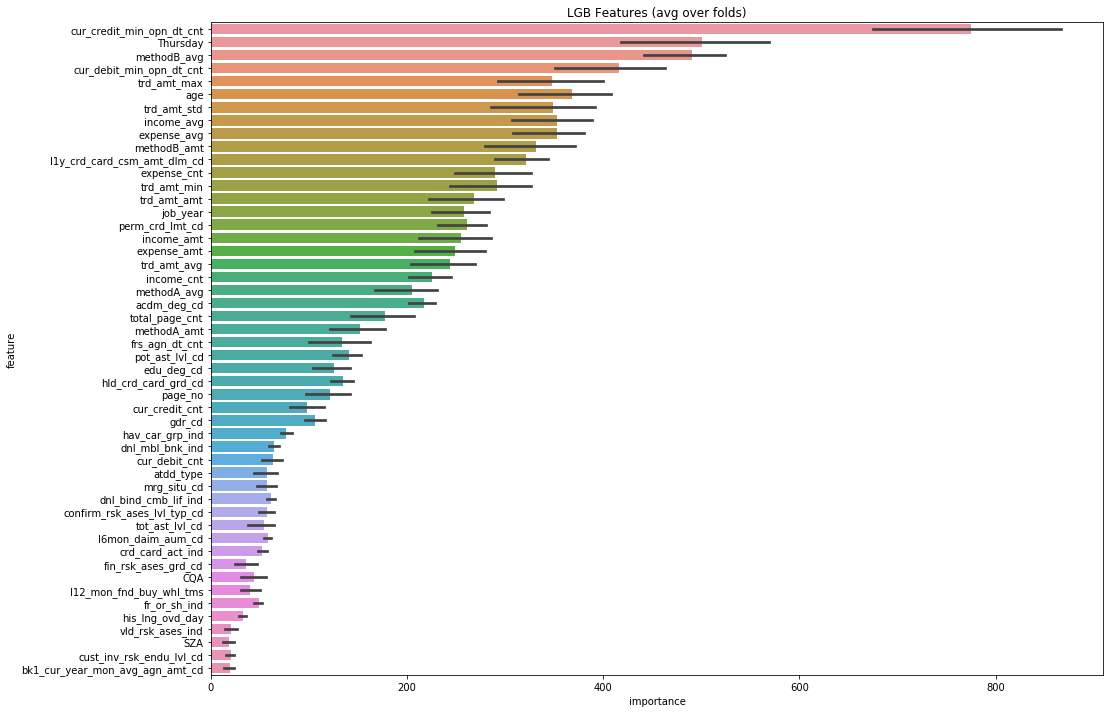

In [158]:
params = {'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'min_data_in_leaf': 300
          #'categorical_feature': cat_cols
         }
result_dict_lgb = train_model_classification(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb', eval_metric='auc', plot_feature_importance=True,
                                                      verbose=500, early_stopping_rounds=200, n_estimators=5000, averaging='usual', n_jobs=-1)

In [159]:
df2=pd.DataFrame(result_dict_lgb['prediction'])
output=test.merge(df2,left_index=True,right_index=True,how='left')
output.columns = ['id', 'probability']
np.savetxt('C:/NEW/fintech/submissionb4.txt', output,fmt='%s\t%f', delimiter="\t", encoding='utf8')  

In [160]:
output.shape

(4000, 2)